# 线性回归
- 假设n个样本，d个特征，则线性和回归的矢量计算表达式为: y = Xw + b
- 其中，X的规模是n * d,w的规模是d * 1
- loss funcion l(x)= 1/2 * 1/n * (y*-y).T * (y* -y)  (X.T * X 就相当与平方和)
- 对参数x的迭代为：x = x - a/n * ∑(dl/dx)
- 其中a是学习率，a和n都是我们自己设定的，因此称为超参数(hyperparameter)，调参调的就是超参数

## 线性回归从0开始


In [1]:
# 导库
%matplotlib inline
from IPython import display
from matplotlib import pyplot as plt
from mxnet import autograd,nd
import random


### 生成数据集
- 设样本数1000,特征2,权重[2,-3.4],b = 4.2,噪声项ε
- y = Xw + b + ε

In [19]:
num_inputs = 2
num_examples = 1000
true_w = [2,-3.4]
true_b = 4.2
features = nd.random.normal(scale = 1, shape = (num_examples, num_inputs))
labels = true_w[0] * features[:,0] + true_w[1] * features[:,1] + true_b
labels += nd.random.normal(scale = 0.01, shape = labels.shape)
'''
test = nd.array(
    [
        [1,2,3],
        [4,5,6],
        [7,8,9]
    ]
)
print(test)
print(test[:,0])
'''


'\ntest = nd.array(\n    [\n        [1,2,3],\n        [4,5,6],\n        [7,8,9]\n    ]\n)\nprint(test)\nprint(test[:,0])\n'

In [33]:
# features每行两个，labels每行一个，代表结果
features[0],labels[0]

(
 [ 0.03870391 -0.2935449 ]
 <NDArray 2 @cpu(0)>,
 
 [5.279657]
 <NDArray 1 @cpu(0)>)

In [42]:
features[:,1]


[-2.93544888e-01 -6.63483679e-01  6.19084597e-01  3.41803998e-01
 -1.73393416e+00 -1.69059360e+00 -1.40938222e+00  1.38275266e-01
 -2.51032138e+00 -8.70430112e-01  4.99850392e-01  6.36423230e-01
 -1.57785320e+00  1.13495362e+00 -1.52358305e+00 -1.63002014e+00
 -1.50970444e-01  9.57236528e-01 -9.84937727e-01  1.41989267e+00
  5.32968581e-01  7.36070216e-01  1.01816428e+00 -9.87999812e-02
 -1.15131056e+00 -1.95075527e-01  6.89685345e-01  9.20113385e-01
 -3.97983789e-01  3.55009913e-01 -1.11858094e+00  3.99474531e-01
  1.16094685e+00 -8.70568454e-01 -5.90775609e-01 -8.14187169e-01
 -3.04481459e+00 -1.27574456e+00  2.50930399e-01  4.55881983e-01
 -6.85899675e-01 -3.15493673e-01 -5.84218621e-01  5.59400260e-01
  1.32386518e+00 -1.27929181e-01  1.56406832e+00 -2.40624156e-02
  4.10144508e-01 -1.23492801e+00  3.17318529e-01  2.66511559e-01
  1.17521822e+00 -8.70280921e-01  2.29176927e+00 -3.64114404e-01
 -3.09064024e-04  2.00858140e+00 -1.18375158e+00 -3.91112447e-01
 -4.45988327e-01  1.3465

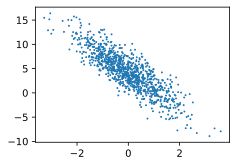

In [32]:
def use_svg_display():
    # 用矢量图显示
    display.set_matplotlib_formats('svg')
def set_figsize(figsize = (3.5, 2.5)):
    use_svg_display()
    # set the size of graph
    plt.rcParams['figure.figsize'] = figsize

set_figsize()
# scatter graph 散点图 ,参数1是设置点的大小
plt.scatter(features[:,1].asnumpy(), labels.asnumpy(),1);


### 读取数据

In [91]:
# 返回batch_size(批量大小)个随机样本的特征和标签
def data_iter(batch_size, features, labels):
    # features 是 1000 * 2，len(features) = 1000，也就是有多少个样本
    num_examples = len(features)
    # 按顺序生成0到num_examples-1的列表
    indices = list(range(num_examples))
    # 打乱列表
    random.shuffle(indices)
    for i in range(0,num_examples,batch_size):
        # 每次选取batch_size个连续的数，转成一个ndarray，并找到对应索引的特征和标签
        j = nd.array(indices[i: min(i + batch_size, num_examples)])
        yield features.take(j), labels.take(j)
        # yield 放最后一行就和return一样

In [92]:
batch_size = 10
# X存features，y存labels
for X,y in data_iter(batch_size, features, labels):
    print(X,y)
    # 这里就取1次
    break


[[-0.13067429 -0.12792918]
 [-0.72166884 -1.2850006 ]
 [ 0.03870391 -0.2935449 ]
 [ 1.1128223   0.7360702 ]
 [-0.31963044  0.29679546]
 [-1.7033416  -1.1297083 ]
 [-0.04917858 -0.6634837 ]
 [ 1.0988613  -1.4426427 ]
 [ 0.1546813  -0.10578862]
 [-1.0072255  -0.8441966 ]]
<NDArray 10x2 @cpu(0)> 
[ 4.374577   7.137256   5.279657   3.9252906  2.538621   4.629594
  6.3582606 11.30575    4.8658485  5.059931 ]
<NDArray 10 @cpu(0)>


### 初始化模型参数

In [93]:
w = nd.random.normal(scale = 0.01, shape = (num_inputs, 1))
b = nd.zeros(shape = (1,))

In [94]:
# 申请梯度存放的内存
w.attach_grad()
b.attach_grad()

### 定义模型

In [95]:
def linreg(X,w,b):
    return nd.dot(X,w) + b

### 定义损失函数

In [96]:
def squared_loss(y_hat,y):
    return (y_hat - y.reshape(y_hat.shape)) ** 2 /2

### 定义优化算法

In [97]:
# params参数向量，lr学习率，batch_size小批量样本的个数
def sgd(params, lr, batch_size):
    for param in params:
        param[:] = param - lr * param.grad / batch_size

### 训练模型

In [98]:
import numpy as np
np.set_printoptions(suppress=True)
lr = 0.03
num_epochs = 3
net = linreg
loss = squared_loss

for epoch in range(num_epochs):
    for X, y in data_iter(batch_size, features, labels):
        with autograd.record():
            l = loss(net(X,w,b), y) #求小批量X和y的损失
        l.backward() #求小批量损失函数的梯度
        sgd([w,b], lr, batch_size) # 优化参数
    train_l = loss(net(features, w, b), labels)
    print('epoch {}, loss {}'.format(epoch + 1, train_l.mean().asnumpy()))

epoch 1, loss [0.02723297]
epoch 2, loss [0.00009329]
epoch 3, loss [0.00004633]


# 小结
- 读取数据，batch_size,注意小批量代码是怎么写的
- 生成数据X，和y
- 初始化w和b
- 定义模型 y = w * x + b
- 定义损失函数 squared_loss = 1/2 * 求和(y_hat-y)^2  
- 定义优化函数，也就是训练我们的参数 θ = θ - lr * θ.grad / batch_size
- 总的思路：反复测试（设置迭代周期），通过小批量的方式，把数据传给模型，然后算出y，进而计算损失，然后通过梯度下降，调整w和b,减小损失。使损失值达到比较理想的状态